# Simulation results

This notebook shows how to analyze simulation results. It goes through both population and epidemic results, and generates several diagnostic plots.

## Running a simulation

We import the Python packages that we are going to use, and initialize the simulation script by sourcing the `hiv_branching_process.R` file.

In [1]:
# Standard packages
import os
import math
import numpy as np
import pandas as pd
import seaborn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


# Additional Python packages for computing the effective reproductive number
import epyestim
from scipy.stats import gamma


# R-related packages
import rpy2
import rpy2.robjects as robjects
r = robjects.r

from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter


# We may need to install some packages
try:
    from rpy2.robjects.packages import importr
    dplyr = importr('dplyr')
except RRuntimeError:
    from rpy2.robjects.packages import importr, data
    utils = importr('utils')
    base = importr('base')
    utils.chooseCRANmirror()
    utils.install_packages('dplyr')


# Set up working directory
cwd = os.getcwd()
os.chdir('../')

In [2]:
r.source('hiv_branching_process.R')

... running simulation with parameters:
      samplesize =  100
      timestep   =  1
      sim_time   =  375
      seed       =  0
      mean_partner_parameter =  0.45
      acts_per_day_parameter =  0.3
      lambda_parameter       =  0.002
      removal_rate_parameter =  0.001
      sampling_delay         =  365
... simulation step  10 /  375
... simulation step  20 /  375
... simulation step  30 /  375
... simulation step  40 /  375
... simulation step  50 /  375
... simulation step  60 /  375
... simulation step  70 /  375
... simulation step  80 /  375
... simulation step  90 /  375
... simulation step  100 /  375
... simulation step  110 /  375
... simulation step  120 /  375
... simulation step  130 /  375
... simulation step  140 /  375
... simulation step  150 /  375
... simulation step  160 /  375
... simulation step  170 /  375
... simulation step  180 /  375
... simulation step  190 /  375
... simulation step  200 /  375
... simulation step  210 /  375
... simulation step 

value,[RTYPES.VECSXP]
visible,[RTYPES.LGLSXP]


We can now run the simulation and convert its outputs into pandas dataframes:

In [3]:
# Run the simulation
out = r.simulate_transmission( sim_time=365*10 )
population_summary_r  = out.rx2('population_summary' )
transmission_record_r = out.rx2('transmission_record')

# Convert R dataframes into pandas dataframes
with localconverter( robjects.default_converter + pandas2ri.converter ):
    population_summary  = robjects.conversion.rpy2py( population_summary_r  )
    transmission_record = robjects.conversion.rpy2py( transmission_record_r )

# Let's define source and recipient id's as strings
population_summary['recipient'] = population_summary['recipient'].astype(int).astype(str)
population_summary['source'] = population_summary['source'].astype(int).astype(str)

# And let's also remove seed infections that didn't generate new infections
seed_infections = population_summary[ (population_summary['source'] == '0') ]['recipient']
seed_infections_with_children    = seed_infections[ seed_infections.isin( population_summary['source'] ) ]
seed_infections_with_no_children = seed_infections[ ~seed_infections.isin( population_summary['source'] ) ]
population_summary_lean = population_summary[ ~population_summary['recipient'].isin(seed_infections_with_no_children) ]

... running simulation with parameters:
      samplesize =  100
      timestep   =  1
      sim_time   =  3650
      seed       =  0
      mean_partner_parameter =  0.5
      acts_per_day_parameter =  0.3
      lambda_parameter       =  0.002
      removal_rate_parameter =  0.001
      sampling_delay         =  365
... simulation step  10 /  3650
... simulation step  20 /  3650
... simulation step  30 /  3650
... simulation step  40 /  3650
... simulation step  50 /  3650
... simulation step  60 /  3650
... simulation step  70 /  3650
... simulation step  80 /  3650
... simulation step  90 /  3650
... simulation step  100 /  3650
... simulation step  110 /  3650
... simulation step  120 /  3650
... simulation step  130 /  3650
... simulation step  140 /  3650
... simulation step  150 /  3650
... simulation step  160 /  3650
... simulation step  170 /  3650
... simulation step  180 /  3650
... simulation step  190 /  3650
... simulation step  200 /  3650
... simulation step  210 /  3650

## Analysis of population parameters

We can characterize the parameters of the population by looking at the instantiation of population parameters such as number of partners, acts per day, transmission risks, etc. Let's check some statistics for these parameters:

In [4]:
population_summary_lean.describe().loc[:, [ 'removal_rate',  
                                            'partners',
                                            'acts_per_day',
                                            'transmission_risk_per_act',
                                            'transmission_risk_per_day'
                                           ]] 

,removal_rate,partners,acts_per_day,transmission_risk_per_act,transmission_risk_per_day
count,4.180000e+03,4180.000000,4180.000000,4180.000000,4180.000000
mean,1.000000e-03,0.968182,0.299115,0.003193,0.000905
std,6.440931e-17,1.359938,0.295042,0.009108,0.005571
min,1.000000e-03,0.000000,0.000028,0.000588,0.000000
25%,1.000000e-03,0.000000,0.087836,0.000902,0.000000
50%,1.000000e-03,0.000000,0.205213,0.001001,0.000000
75%,1.000000e-03,1.000000,0.420003,0.001114,0.000353
max,1.000000e-03,11.000000,2.931600,0.057342,0.129188


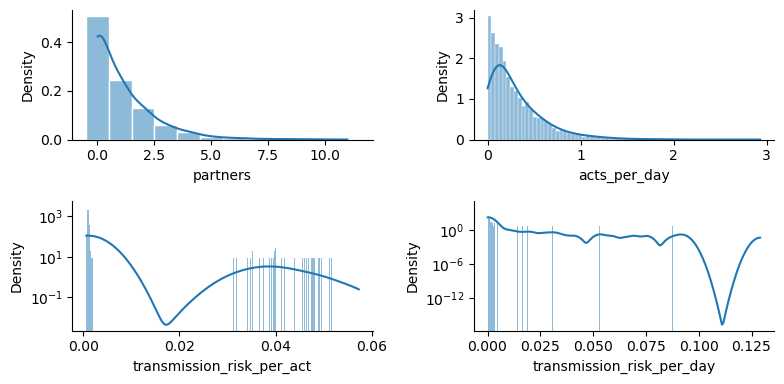

In [5]:
# Drawing histograms and computing KDE for some population parameters
population_params = [ 'partners', 'acts_per_day', 'transmission_risk_per_act', 'transmission_risk_per_day' ]

ncols = 2
nrows = math.ceil( len(population_params)/ncols )
fig, axs = plt.subplots( nrows, ncols, figsize=(4*ncols, 2*nrows) )
seaborn.set_theme( style='ticks' )

for i, param_name in enumerate(population_params):
    discrete_param = True if param_name in ['partners'] else False
    logy = True if param_name in ['transmission_risk_per_act', 'transmission_risk_per_day'] else False
    seaborn.histplot( population_summary_lean[param_name],
                      stat     = 'density',
                      discrete = discrete_param,
                      kde      = True,
                      log_scale = (False,logy),
                      kde_kws  = {'bw_adjust': 2},
                      ax       = axs[int(i/ncols), i%ncols]
                    )
    seaborn.despine()
fig.tight_layout()                      

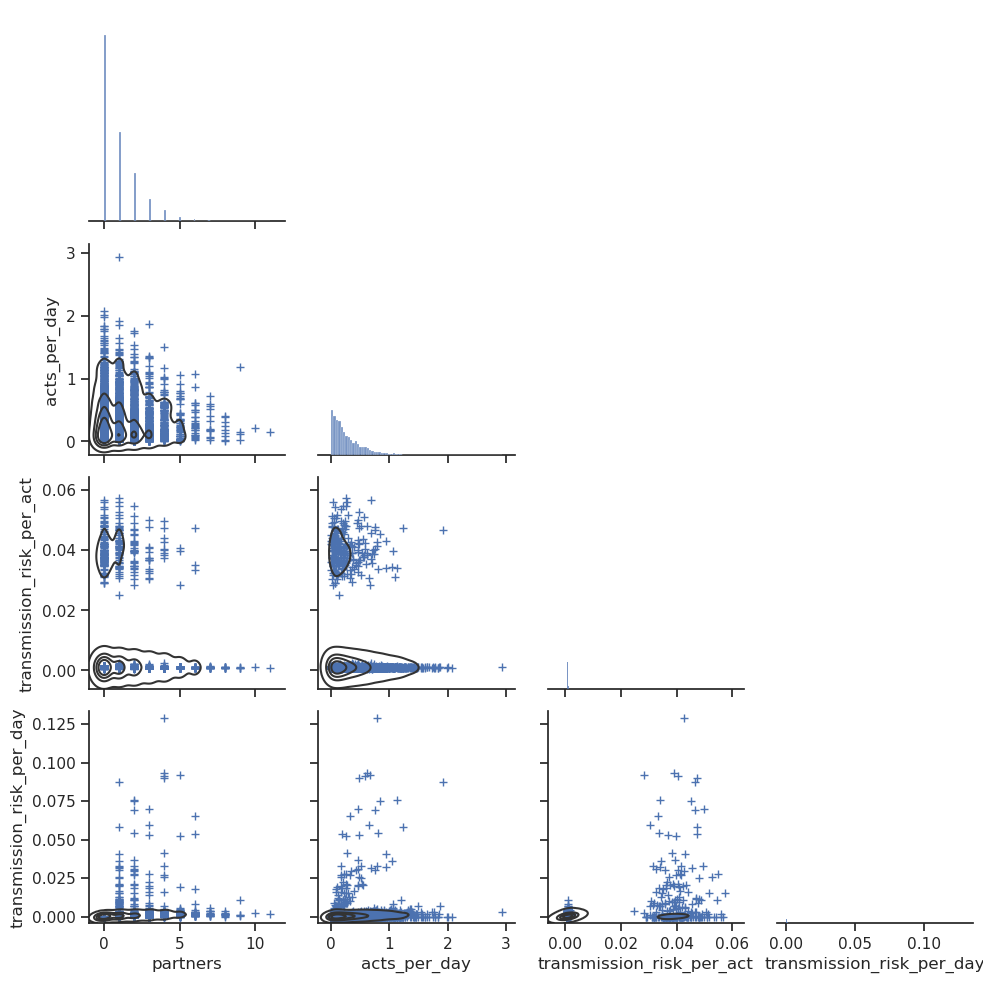

In [6]:
# At this point, we shouldn't see any correlation
pop_pairplot = seaborn.pairplot( population_summary_lean, 
                                 vars     = population_params, 
                                 height   = 2.5, 
                                 corner   = True,
                                 plot_kws = dict( marker='+', linewidth=1 )
                                )
pop_pairplot.map_lower( seaborn.kdeplot, levels=5, color='.2' )

## How does the distribution of serial intervals look?

As part of the validations that help us ensure that the simulation looks realistic, we could look at the distribution of serial intervals (i.e., times between successive cases in a chain of transmission). This results is also used later in this notebook when estimating the effective reproductive number.

/tmp/ipykernel_2535779/3402635340.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_summary_lean.loc[index, 'serial_interval'] = serial_interval


<Axes: >

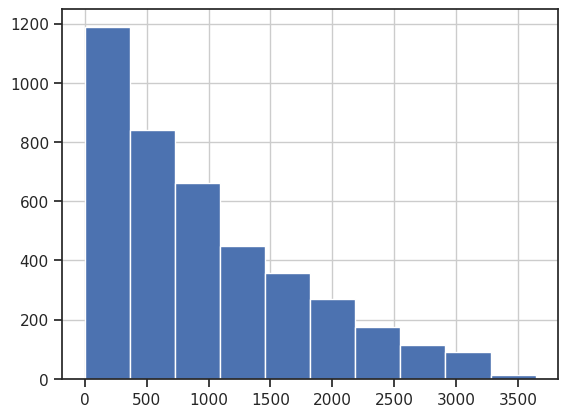

In [7]:
infection_times = population_summary_lean.loc[:, ['recipient', 'infectionTime'] ]
infection_times.head()

count =0 
for index, row in population_summary_lean.iterrows():
    recipient     = row['recipient']
    source        = row['source'   ]
    infectionTime = row['infectionTime']
    if source != '0':
        infectionTime_source = infection_times[ infection_times['recipient']==source ]['infectionTime'].item()
        serial_interval = infectionTime - infectionTime_source
    else:
        serial_interval = np.nan
    population_summary_lean.loc[index, 'serial_interval'] = serial_interval
    
population_summary_lean['serial_interval'].hist()

## Epidemic trajectory

Finally, let's get the timeseries of cases generated by our simulation:

In [8]:
infection_count = pd.DataFrame()
infection_count['number_of_infections' ] = population_summary_lean.groupby('infectionTime').count().iloc[:,0]
infection_count['cumulative_infections'] = infection_count['number_of_infections'].cumsum()

We can also estimate the effective reproductive number:

In [9]:
# Fit a Gamma distribution that models the serial intervals
a, loc, scale  = gamma.fit(population_summary_lean['serial_interval'].dropna().values)
si_distribution = epyestim.distributions.discretise_gamma( a, scale, loc )

# Estimate the effective reproductive number (we need a timeseries so we are using an arbitrary start date)
cases = pd.Series( data = infection_count['number_of_infections'].values, 
                   index=pd.date_range('1/1/1950', periods=len(infection_count)) )
r_eff = epyestim.bagging_r( cases,
                            si_distribution,
                            np.array([1]),
                            a_prior = 3,
                            b_prior = 1,
                            r_window_size = 7,
                            smoothing_window = 7
                           )

# Extract relevant estimates and add them to our infection_count dataframe
days_diff = ( r_eff.index[0] - pd.to_datetime('1/1/1950') ).days # there are no estimates at the beginning of the time series
padding = np.full( days_diff, np.nan )
infection_count['R_eff'   ] = np.concatenate( ( padding, r_eff['R_mean'].values ) )
infection_count['R_q0.025'] = np.concatenate( ( padding, r_eff['Q0.025'].values ) )
infection_count['R_q0.975'] = np.concatenate( ( padding, r_eff['Q0.975'].values ) )

Let's plot our results:

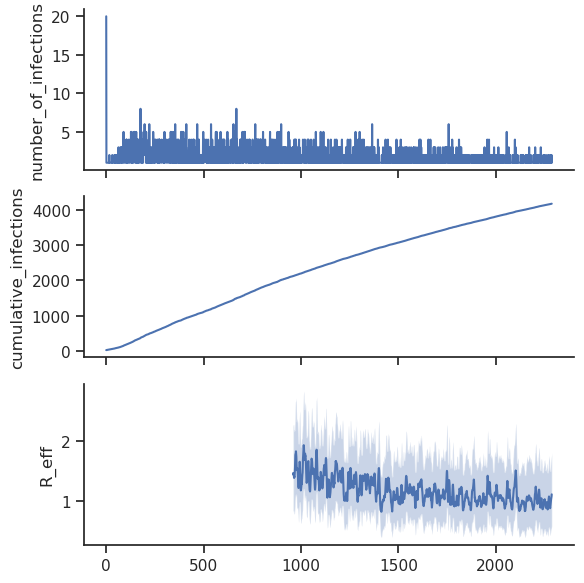

In [10]:
fig_trj, axs_trj = plt.subplots( 3, 1, figsize=(6, 6), sharex=True )
x_trj = range(len(infection_count))

seaborn.set_style( 'whitegrid' )

seaborn.lineplot( infection_count,
                  x  = x_trj,
                  y  = 'number_of_infections',
                  ax = axs_trj[0]
                 )
seaborn.despine()

seaborn.lineplot( infection_count,
                  x  = x_trj,
                  y  = 'cumulative_infections',
                  ax = axs_trj[1]
                 )
seaborn.despine()

seaborn.lineplot( infection_count,
                  x  = x_trj,
                  y  = 'R_eff',
                  ax = axs_trj[2]
                 )
seaborn.despine()

axs_trj[2].fill_between( x_trj, 
                         infection_count['R_q0.025'],
                         infection_count['R_q0.975'],
                         alpha = 0.3
                       )

fig_trj.tight_layout()